In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
from math import sqrt

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

from scipy.stats import pearsonr
from matplotlib.font_manager import FontProperties



file = './dataset/SST.nc'
dataset = nc.Dataset(file)
# print(dataset.variables.keys())

longitude, latitude = dataset.variables['longitude'],dataset.variables['latitude']
time = dataset.variables['time']
sst =dataset.variables['sst']

cor_num = pd.read_excel(io = r'./dataset/SI0719.xlsx')
coordinate = cor_num['SI'].tolist()

In [16]:
def MeanYear(year):
    num_month = 5
    month_1980 = (year - 1870) * 12 - 1
    sum_month_year =  np.zeros(sst[:1].data[0][44:136,:].shape, 
                                           dtype=float, order='C')
    for i in range(month_1980, month_1980+num_month):
        tmp_pre = sst[month_1980:month_1980+i].data[0][44:136,:]
        sum_month_year += tmp_pre
    mean_year = sum_month_year / num_month
    return mean_year

MeanYear(1981)

array([[ 5.77108192,  5.82056093,  6.1402483 , ...,  6.11834335,
         6.10076714,  5.98622894],
       [ 6.85625982,  6.87017488,  7.15798712, ...,  7.17761993,
         7.2130084 ,  7.10566616],
       [ 8.05367565,  8.07085133,  8.37101364, ...,  8.27058697,
         8.37865448,  8.30329895],
       ...,
       [14.1102829 , 14.00843811, 13.80558491, ..., 13.51718426,
        13.90095806, 14.09959984],
       [13.34961987, 13.29618454, 13.13221741, ..., 12.92348862,
        13.13108444, 13.27401543],
       [12.88537788, 13.035429  , 13.03612518, ..., 12.25678253,
        12.35687447, 12.56465721]])

In [17]:
# 计算1980到2004的前一年12到当年4月的平均 总25年
def MeanPhase(startYear, endYear):
    numYear = endYear-startYear
    Mean = np.zeros(sst[0:numYear,44:136,:].data.shape,
                          dtype=float, order='C')
    for year in range(startYear, endYear):
        tmp_mean_each_year = np.zeros(sst[:1].data[0][44:136,:].shape, 
                                           dtype=float, order='C')
        for i in range(year-2, year+3):
            tmp_mean_each_year += MeanYear(i)
        Mean[year-endYear] = tmp_mean_each_year/5
    return Mean



In [10]:
MeanYear(2023).shape

(92, 360)

In [19]:
cor_num

,SEASON,SI
0,1980,16
1,1981,13
2,1982,19
3,1983,9
4,1984,23
5,1985,22
6,1986,21
7,1987,12
8,1988,13
9,1989,17


In [47]:
import time
start = time.time()

# Mean1982to2002 = MeanPhase(1982, 2003) 计算1980-2006
# 滑动平均实际计算1982到2004年的数据
First = MeanPhase(1982, 2005)

# Mean2009to2021 = MeanPhase(2009, 2022)
# 如上计算2011-2021的数据
Second = MeanPhase(2011, 2022)

end = time.time()

print("Custom time is %f"%(end - start))

Custom time is 124.329373


In [48]:
First.shape

(23, 92, 360)

In [49]:
Second.shape

(11, 92, 360)

In [34]:
ls = [16.2,16.6,15.8,15.2,15.8,15,14,13.2,14,14,15.8,15.4,15.6]

len(ls)

13

In [35]:
cor_num = pd.read_excel(io = r'./dataset/SI0922.xlsx')
coordinate = cor_num['5AV.SI'].tolist()

In [36]:
len(coordinate)

44

In [39]:
time

<class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    units: days since 1870-1-1 0:0:0
    calendar: gregorian
    long_name: Time
    standard_name: time
unlimited dimensions: time
current shape = (1840,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [55]:
# 对数据进行转置
reshape_mean_1980to2004 = First.transpose(1,2,0)
reshape_mean_2005to2023 = Second.transpose(1,2,0)

def PearsonMatrix(reshape_mean):
    pearson_matrix = np.zeros((92,360), dtype=float, order='C')
    p_value = np.zeros((92,360), dtype=float, order='C')
    for i in range(len(reshape_mean)):
        for j in range(len(reshape_mean[i])):
            x = reshape_mean[i][j]
            if len(x) == 25:
                y = coordinate[:25]
            elif len(x) == 19:
                y = coordinate[25:]
            elif len(x) == 21:
                y = [16,17.2,18.8,17.4,18.2,17,16.2,14.8,15.4,15.4,16.4,15.8,17.2,18.4,19.2,18.8,19.4,18.4,17.6,17.8,17.2]
            elif len(x) == 13:
                y = [16.2,16.6,15.8,15.2,15.8,15,14,13.2,14,14,15.8,15.4,15.6]
            elif len(x) == 23:
                y = coordinate[2:25]
            elif len(x) == 11:
                y = coordinate[29:40]
            else:
                print("Error, the dimension x and y ")
            tmp_correlation, _ = pearsonr(x, y)
    #         print(tmp_correlation)
            pearson_matrix[i][j] = tmp_correlation
            p_value[i][j] = _
    pearson_matrix = np.nan_to_num(pearson_matrix)
    return pearson_matrix, p_value

pearson_matrix_1980to2004, p_value_1980to2004 = PearsonMatrix(reshape_mean_1980to2004)
pearson_matrix_2005to2023, p_value_2005to2023 = PearsonMatrix(reshape_mean_2005to2023)

In [56]:
p_value_1980to2004[np.isnan(p_value_1980to2004)] = 0
p_value_2005to2023[np.isnan(p_value_2005to2023)] = 0


In [57]:
print(pearson_matrix_1980to2004.max(), pearson_matrix_1980to2004.min())
print(pearson_matrix_2005to2023.max(), pearson_matrix_2005to2023.min())

0.8249445850914784 -0.9065563142643238
0.947828192978199 -0.9234464114710774


In [58]:
print(p_value_1980to2004.max(), p_value_1980to2004.min())
print(p_value_2005to2023.max(), p_value_2005to2023.min())

0.9998053980532103 0.0
0.9997992995201488 0.0


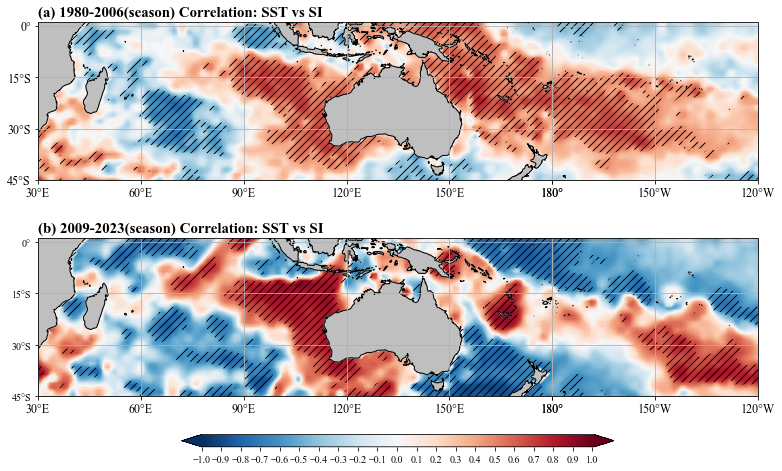

In [61]:

plt.rc('font',family='Times New Roman') 
lon = longitude[:].data
lat = latitude[44:136].data
MAX = 1.01
MIN = -1.0
data_phase1 = pearson_matrix_1980to2004 
data_phase2 = pearson_matrix_2005to2023
pvalue1 = p_value_1980to2004
pvalue2 = p_value_2005to2023

# 调整经纬度 向东偏移180
lon_pacific_1980to2004 = lon[:] + 180
a, b = np.hsplit(data_phase1, [179])
data_phase1 = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据

#设置填色图投影方式，以及地图边界
proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (30, 180, -45, 1)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
#建立画布
fig = plt.figure(figsize=(10,10))
# 添加第一个子图
fig_ax1 = fig.add_axes([0, 0.4, 1, 1], projection = proj)

fig_ax1.contourf(lon, lat, pvalue1,
            [np.nanmin(pvalue1), 0.05, np.nanmax(pvalue1)],
#                  [0.2, 0.65, 1],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
# 切割图
xticks_list = np.hstack((np.arange(30,180.1,30) , np.arange(-180,-90.1,30)))
fig_ax1.set_xticks(xticks_list, crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,1,15), crs=ccrs.PlateCarree())
labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a) 1980-2006(season) Correlation: SST vs SI',fontweight='bold',
                  loc='left',fontsize =15)

cont_ax1 = fig_ax1.contourf(lon_pacific_1980to2004, lat, data_phase1, 
                 levels=np.arange(MIN, MAX, 0.01),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)


# ====================子图2======================
# 调整经纬度 向东偏移180
lon_pacific_2005to2023 = lon[:] + 180
c, d = np.hsplit(data_phase2, [179])
data_phase2 = np.concatenate([d, c], axis=1) # 转换为以太平洋为中心的数据

fig_ax2 = fig.add_axes([0, 0.1, 1, 1], projection = proj)

fig_ax2.contourf(lon, lat, pvalue2,
            [np.nanmin(pvalue2), 0.05, np.nanmax(pvalue2)],
#                  [0.3, 0.35, np.nanmax(pvalue2)],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax2.add_feature(land,facecolor='0.75')
fig_ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax2.set_xticks(xticks_list, crs=ccrs.PlateCarree())
fig_ax2.set_yticks(np.arange(-45,1,15), crs=ccrs.PlateCarree())
labels = fig_ax2.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax2.grid() # 增加网格

fig_ax2.xaxis.set_major_formatter(lon_formatter)
fig_ax2.yaxis.set_major_formatter(lat_formatter)

fig_ax2.set_title('(b) 2009-2023(season) Correlation: SST vs SI',fontweight='bold',
                  loc='left',fontsize =15)
cont_ax2 = fig_ax2.contourf(lon_pacific_2005to2023, lat, data_phase2, 
                 levels=np.arange(MIN, MAX, 0.01),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }

norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值

position = fig.add_axes([0.2, 0.42, 0.6, 0.017]) # 最下面位置

# c1 = fig_ax2.contourf(lon_pacific_1998to2021, lat, data_1998to2021, levels=np.arange(-0.9,1.0,0.1), zorder=0, extend = 'both', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)

fc2=fig.colorbar(
                mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
#                 c1,
                 cax=position,
                 orientation='horizontal',
                 ticks=np.arange(MIN, MAX, 0.1).tolist(),                                                    
                 extend='both',
                fraction=0.012) 

fc2.set_label(label="", fontdict=font) #设置colorbar的标签字体及其大小


plt.savefig("sst_correl_12toNext4.png",dpi=300,bbox_inches='tight')

plt.show()